# Setup

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-b5356651-0d8e-5cd1-bdf3-ccbb8b221031"

import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
# from tensorflow.keras import layers
import numpy as np
from numpy.random import default_rng
import scipy.linalg as la
from scipy.special import gammaln
import scipy.cluster.vq as vq
import matplotlib.pyplot as plt
import pymc as pm
import pytensor.tensor as pt
import arviz as az
import netCDF4 as nc
import re
import pandas as pd
import sklearn as skl
import seaborn as sns
import tuning_fun as tu
import emulator_fun as ef

2025-04-01 12:44:00.315935: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-01 12:44:00.326883: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743525840.339501 1507152 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743525840.343306 1507152 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-01 12:44:00.358192: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# allocating GPU memory

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# model

## read files

In [ ]:
case_name = 'condevp_withcoal'
base_path = '/home/arthurhu/BOSS_PPE/PPE csv/'
ppe_params_fn = case_name + '_ppe_params.csv'
# ppe_params_valid_fn = 'condcoll_ppe_isd_def0.2_valid_ppe_params.csv'
ppe_sim_fn = case_name + '_LWP234_ppe_var.csv'
# ppe_sim_fn = 'condcoll_ppe_isd_cwcrwc_ppe_var.csv'
# ppe_sim_valid_fn = 'condcoll_ppe_isd_def0.2_valid_ppe_var.csv'
# target_var_fn = 'condcollboss_4m_3069_cwcrwc_target_var.csv'
target_var_fn = case_name + '_LWP234_target_var.csv'

param_all_idx = np.arange(40)
# REVIEW: check every time if this is true ... not sure how to implement this programatically
# param_interest_idx = np.arange(12)
# param_interest_idx = np.arange(16,28)
param_interest_idx = np.concatenate((np.arange(0,8), np.arange(16,28)))
param_not_int_idx = [i for i in param_all_idx if i not in param_interest_idx]

param_train = ef.get_params(base_path, ppe_params_fn, param_interest_idx)
# param_valid = ef.get_params(base_path, ppe_params_valid_fn, param_interest_idx)

# slim down the output sets
# output_slim = np.concatenate(([0],np.arange(1,62,4)), dtype=int)
output_slim = []
ppe_sim_train = ef.get_vars(base_path, ppe_sim_fn, slim_down=output_slim)
# ppe_sim_valid = ef.get_vars(base_path, ppe_sim_valid_fn, slim_down=output_slim)
tgt_sim = ef.get_vars(base_path, target_var_fn, slim_down=output_slim)

n_tgt_ics = tgt_sim['vals'].shape[0] 
n_input = param_train['vals'].shape[1]
nobs = ppe_sim_train['vals'].shape[1]
npar = n_input - 2

/home/arthurhu/BOSS_PPE/emulator_fun.py:22: RuntimeWarning: divide by zero encountered in log10
  var_vals_log = np.log10(var_vals)
/home/arthurhu/BOSS_PPE/emulator_fun.py:22: RuntimeWarning: invalid value encountered in log10
  var_vals_log = np.log10(var_vals)
/home/arthurhu/BOSS_PPE/emulator_fun.py:22: RuntimeWarning: divide by zero encountered in log10
  var_vals_log = np.log10(var_vals)
/home/arthurhu/BOSS_PPE/emulator_fun.py:22: RuntimeWarning: invalid value encountered in log10
  var_vals_log = np.log10(var_vals)


In [ ]:
minmaxscale = skl.preprocessing.MinMaxScaler().fit(param_train['vals'])
x_all = minmaxscale.transform(param_train['vals'])
# x_val = minmaxscale.transform(param_valid['vals'])

eff0 = np.array([1e-12, 100, 1e-27, 1e-42])

y_thresholds = np.zeros(ppe_sim_train['vals'].shape[1])
y_thresholds[0] = eff0[0]
y_thresholds[1] = eff0[1]
# y_thresholds[2] = 1e-5
y_thresholds[2] = eff0[2]
y_thresholds[3] = eff0[3]
# y_thresholds[4:64] = 1e-5
y_thresholds[4:3604] = eff0[0]
y_thresholds[3604:7204] = eff0[1]
y_thresholds[7204:10804] = eff0[2]
y_thresholds[10804:] = eff0[3]

# ppe_sim_train['vals'][np.isinf(ppe_sim_train['log_vals'])] = np.nan
# # ppe_sim_train['log_vals'][np.isinf(ppe_sim_train['log_vals'])] = np.nan
# standscale = skl.preprocessing.StandardScaler().fit(ppe_sim_train['vals'])
# y_all_wpresence = (ppe_sim_train['vals'] > y_thresholds).astype('float32')
# # y_val_wpresence = (ppe_sim_valid['vals'] > y_threshold).astype('float32')

# y_log = ppe_sim_train['log_vals']
# y_log[~np.isfinite(y_log)] = np.nan
# y_log[ppe_sim_train['vals'] < y_thresholds] = np.nan
# standscale = skl.preprocessing.StandardScaler().fit(ppe_sim_train['log_vals'])
# y_all = standscale.transform(y_log)
# y_tgt = tgt_sim['log_vals'][:,2:]
# y_tgt[np.isinf(y_tgt)] = np.nan
# y_tgt[tgt_sim['vals'][:,2:] < y_thresholds] = np.nan
# tgt_all = standscale.transform(y_tgt).astype('float32')

y_lin = ppe_sim_train['vals']
y_lin[ppe_sim_train['vals'] < y_thresholds] = np.nan
y_lin[~np.isfinite(y_lin)] = np.nan
y_asinh = ef.smooth_linlog(y_lin, y_thresholds)
standscale = skl.preprocessing.StandardScaler().fit(y_asinh)
y_all = standscale.transform(y_asinh).astype('float32')
y_all_wpresence = (ppe_sim_train['vals'] > y_thresholds).astype('float32')

tgt_lin = tgt_sim['vals'][:,2:]
tgt_lin[tgt_sim['vals'][:,2:] < y_thresholds] = np.nan
tgt_lin[~np.isfinite(tgt_lin)] = np.nan
tgt_asinh = ef.smooth_linlog(tgt_lin, y_thresholds)
tgt_all = standscale.transform(tgt_asinh).astype('float32')
tgt_sim_ics = tgt_sim['vals'][:,:2]

/home/arthurhu/BOSS_PPE/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/arthurhu/BOSS_PPE/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/arthurhu/BOSS_PPE/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


(array([ 332.,  184.,  767., 1079., 1492., 1683., 1523., 1122., 5278.,
        6967.]),
 array([-2.2379117 , -1.89979672, -1.56168175, -1.22356677, -0.88545179,
        -0.54733682, -0.20922184,  0.12889314,  0.46700811,  0.80512309,
         1.14323807]),
 <BarContainer object of 10 artists>)

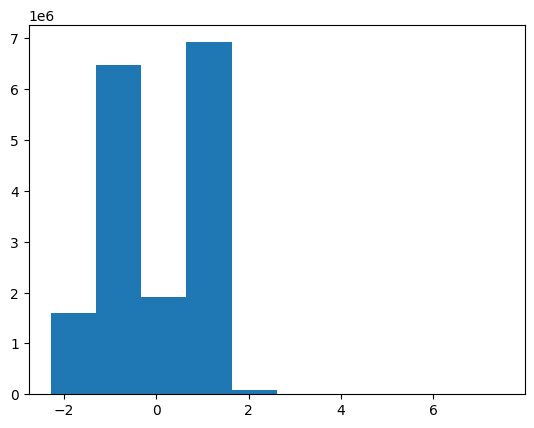

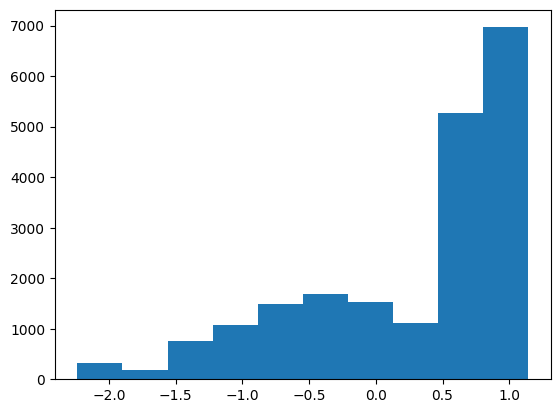

In [ ]:
# np.sum(ppe_sim_train['vals'] > y_thresholds)
# test = np.log10(tgt_sim['vals'][0,7204:10804])
# test_finite = test[np.isfinite(test)]
a = 10800
# ytrue = tgt_sim['vals'][:,a+6:a+3606]
# ytrue[~np.isfinite(ytrue)] = np.nan
# plt.hist(ytrue.flatten())
# plt.figure()
plt.hist(y_all[:,a+4:a+3604].flatten())
plt.figure()
plt.hist(tgt_all[:,a+4:a+3604].flatten())

In [ ]:
y_all.shape

(10000, 14404)

In [ ]:
# cc_model = tf.keras.models.load_model('condcoll_multioutput_try5_no_dropout.keras', compile=False)
cc_model = tf.keras.models.load_model('models/multioutput_try28_condcoll_fullmom_nopartition_asinh.keras', compile=False)


I0000 00:00:1743526527.737531 1507152 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 29431 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 3g.40gb, pci bus id: 0000:e1:00.0, compute capability: 8.0


In [8]:
# REVIEW: check every time if this is true ... not sure how to implement this programatically
param_table = pd.read_csv('/home/arthurhu/Cloud_BOSS/param_consolid.csv')
param_names = param_table.columns[param_interest_idx + 1].to_list()
param_mean = param_table.values[0, param_interest_idx + 1].astype(np.float32)
param_std = param_table.values[1, param_interest_idx + 1].astype(np.float32)
# param_std[param_not_int_idx] = 0

## run

In [91]:
valid_mask.shape

TensorShape([16, 14404])

In [117]:
tfd = tfp.distributions

# tf.keras.backend.set_floatx('float32')
IC_with_dummy = np.concatenate((tgt_sim_ics, np.zeros([n_tgt_ics, npar])), axis=1)
IC_norm = minmaxscale.transform(IC_with_dummy)[:,:2].astype('float32')
valid_mask = tf.math.is_finite(tgt_all)
weights = np.ones([n_tgt_ics, nobs]).astype('float32')
# weights[:,2] = 2
# weights[:,3] = 4
# weights[:,7204:10804] = weights[0,2]
# weights[:,10804:] = weights[0,3]
# IC_with_dummy = np.concatenate((tgt_sim_ics[test_ic], np.zeros(16))).reshape(1, -1)
# IC_norm = MMS_input.transform(IC_with_dummy)[0, :2].astype('float32')
# TODO: weighted logprob

def target_log_prob_fn(params):
    params_2d = tf.tile(params[None, :], [n_tgt_ics,1]) # n_tgt_ics x npar, 16 x 12

    param_lp = tf.reduce_sum(tfd.Uniform(low=tf.constant(0.0, dtype=tf.float32),
                                         high=tf.constant(1.0, dtype=tf.float32)).log_prob(params_2d))

    # get normalized ICs
    input_norm = tf.concat([IC_norm, params_2d], axis=1) # n_tgt_ics x n_input, 16 x 14

    y_emu = cc_model(input_norm) # 2 * n_tgt_ics x nobs, 16 x 7202

    # emulated water presence
    y_emu_wpresence = tf.cast(y_emu[0], tf.float32)
    # FIXME: retrain the model usign logits to avoid arbitrary eps threshold
    eps = 1e-7
    y_emu_wpresence_clipped = tf.clip_by_value(y_emu_wpresence, eps, 1 - eps) # to avoid NaN in log likelihood
    valid_mask_float = tf.cast(valid_mask, tf.float32)
    wpresence_lps = tfp.distributions.Bernoulli(probs=y_emu_wpresence_clipped).log_prob(valid_mask_float)
    wpresence_lp = tf.reduce_sum(wpresence_lps)

    # # emulated observed value
    y_emu_obs_norm = y_emu[1]
    y_emu_obs_norm_valid = tf.boolean_mask(y_emu_obs_norm, valid_mask)
    # y_emu_obs_norm_valid = tf.where(tf.math.is_nan(y_emu_obs_norm_valid), tf.constant(-20, dtype=y_emu_obs_norm_valid.dtype), y_emu_obs_norm_valid)
    tgt_all_valid = tf.boolean_mask(tgt_all, valid_mask)
    weights_valid = tf.boolean_mask(weights, valid_mask)
    obs_lps = tfd.Normal(loc=tf.cast(y_emu_obs_norm_valid, tf.float32), scale=1.).log_prob(tf.cast(tgt_all_valid, tf.float32))*weights_valid
    obs_lp = tf.reduce_sum(obs_lps)

    return param_lp + wpresence_lp + obs_lp

num_burnin_steps = 5000
num_samples = 100000

# 1) Base NUTS kernel
nuts_kernel = tfp.mcmc.NoUTurnSampler(
    target_log_prob_fn=target_log_prob_fn,
    step_size=0.1
)

# 2) Wrap with DualAveragingStepSizeAdaptation for step-size tuning
nuts_kernel2 = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=nuts_kernel,
    num_adaptation_steps=int(num_burnin_steps * 0.8),  # e.g., adapt 80% of burn-in
    target_accept_prob=0.8
)

adaptive_nuts = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel=nuts_kernel,
    num_adaptation_steps=num_burnin_steps,  # number of adaptation steps during burn-in
    target_accept_prob=0.8     # target acceptance probability
)

adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob_fn,
        num_leapfrog_steps=3,
        step_size=0.1),
    num_adaptation_steps=int(num_burnin_steps * 0.8))

MALA_kernel = tfp.mcmc.MetropolisAdjustedLangevinAlgorithm(
        target_log_prob_fn=target_log_prob_fn,
        step_size=0.00001)

RWM_kernel = tfp.mcmc.RandomWalkMetropolis(
    target_log_prob_fn=target_log_prob_fn,
    new_state_fn=tfp.mcmc.random_walk_normal_fn(scale=0.00005)
)

nchains = 8

@tf.function
def run_chain():
    initial_state = tf.zeros([npar], dtype='float32') + 0.5

    return tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_state,
        kernel=RWM_kernel,
        trace_fn=(lambda current_state, kernel_results: kernel_results),
        seed=42
    )

samples, kernel_results = run_chain()

In [118]:
initial_state = tf.zeros([npar], dtype='float32') + 0.5
print("Initial log probability:", target_log_prob_fn(initial_state).numpy())
print("acceptance rate:", sum(kernel_results.is_accepted.numpy())/num_samples)
# print("acceptance rate:", sum(kernel_results.inner_results.is_accepted.numpy())/num_samples)

Initial log probability: -112174.56
acceptance rate: 0.28507


# postprocessing

In [119]:
samples

<tf.Tensor: shape=(100000, 12), dtype=float32, numpy=
array([[0.5104789 , 0.5074531 , 0.50696903, ..., 0.50176626, 0.50365895,
        0.50768375],
       [0.5104789 , 0.5074531 , 0.50696903, ..., 0.50176626, 0.50365895,
        0.50768375],
       [0.5104789 , 0.5074531 , 0.50696903, ..., 0.50176626, 0.50365895,
        0.50768375],
       ...,
       [0.52269053, 0.50903773, 0.5052705 , ..., 0.49877438, 0.5159008 ,
        0.5286175 ],
       [0.5226552 , 0.5090862 , 0.5052562 , ..., 0.49879396, 0.515876  ,
        0.5286013 ],
       [0.5226552 , 0.5090862 , 0.5052562 , ..., 0.49879396, 0.515876  ,
        0.5286013 ]], dtype=float32)>

In [120]:
Na_norm = IC_norm[0,0].astype('float32')
Na_col = tf.fill([tf.shape(samples)[0], 1], Na_norm)
w_norm = IC_norm[0,1].astype('float32')
w_col = tf.fill([tf.shape(samples)[0], 1], w_norm)
samples_with_ic = tf.concat([Na_col, w_col, samples], axis=1)
samples_with_ic
samples_with_ic_raw_vals = minmaxscale.inverse_transform(samples_with_ic)
samples_raw_vals = samples_with_ic_raw_vals[:,2:]

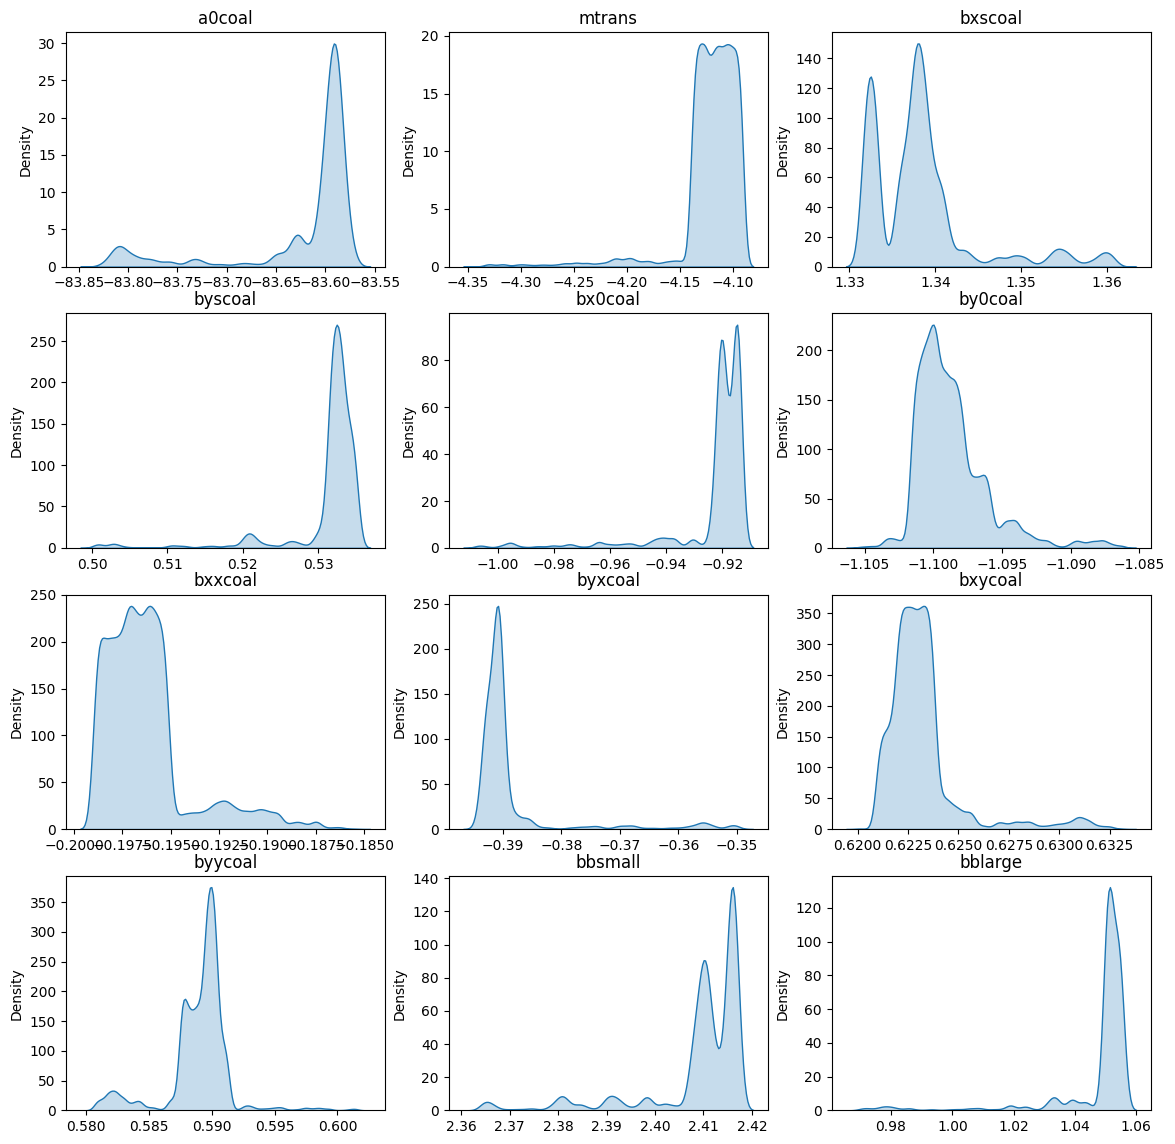

In [121]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(14,14))
gs = gridspec.GridSpec(4, 3)
for iparam, param_name in enumerate(param_names):
    ax = fig.add_subplot(gs[iparam])
    sns.kdeplot(samples_raw_vals[:,iparam], fill=True)
    plt.title(param_name)
    # plt.plot((param_mean[iparam], param_mean[iparam]), ax.get_ylim(), color='tab:red')

plt.show()

# sns.pairplot(df_samples, corner=True, kind="kde")
# plt.show()

##  save distribution for PPE

In [122]:
nbins = 50
count = {}
bins = {}
# count = np.zeros([nbins, npar])
# bins = np.zeros([nbins + 1, npar])
for iparam, param_name in enumerate(param_names):
    count[param_name], bins[param_name] = np.histogram(samples_raw_vals[:, iparam], bins=nbins)
    count[param_name] = count[param_name]/np.sum(count[param_name])

In [123]:
samples_raw_vals

array([[-83.82872927,  -4.29743754,   1.33881535, ...,   0.60184632,
          2.36623381,   0.9700627 ],
       [-83.82872927,  -4.29743754,   1.33881535, ...,   0.60184632,
          2.36623381,   0.9700627 ],
       [-83.82872927,  -4.29743754,   1.33881535, ...,   0.60184632,
          2.36623381,   0.9700627 ],
       ...,
       [-83.58451949,  -4.13898568,   1.33202133, ...,   0.58988033,
          2.41519527,   1.0537911 ],
       [-83.58522634,  -4.13414022,   1.33196411, ...,   0.58995864,
          2.4150961 ,   1.05372626],
       [-83.58522634,  -4.13414022,   1.33196411, ...,   0.58995864,
          2.4150961 ,   1.05372626]])

In [124]:
pd.DataFrame.from_dict(count).to_csv('MCMC_posterior/' + case_name + '_r1_param_density_RWM.csv', index=False)
pd.DataFrame.from_dict(bins).to_csv('MCMC_posterior/' + case_name + '_r1_param_bins_RWM.csv', index=False)

In [17]:
case_name

'condcoll'

## update params csv

In [125]:
original_params = pd.read_csv('/home/arthurhu/Cloud_BOSS/param_consolid.csv')
updated_params = original_params.copy()
for iparam, param_name in enumerate(param_names):
    binmean = (bins[param_name][1:] + bins[param_name][:-1])/2
    weighted_mean = np.average(binmean, weights=count[param_name])
    updated_params.loc[0, param_name] = weighted_mean

# coal_density = pd.read_csv('MCMC_posterior/coal_r2_param_density.csv')
# coal_param_names = coal_density.keys()[1:].to_list()
# coal_bin_edges = pd.read_csv('MCMC_posterior/coal_r2_param_bins.csv')

# for iparam, param_name in enumerate(coal_param_names):
#     binmean = (coal_bin_edges[param_name][1:].to_numpy() + coal_bin_edges[param_name][:-1].to_numpy())/2
#     weighted_mean = np.average(binmean, weights=coal_density[param_name])
#     updated_params.loc[0, param_name] = weighted_mean

updated_params.to_csv('/home/arthurhu/Cloud_BOSS/param_consolid_updated.csv', index=False)

## validation

In [109]:
IC_norm

array([[0.02171889, 0.02165612],
       [0.02171889, 0.13036914],
       [0.02171889, 0.3477952 ],
       [0.02171889, 0.78264725],
       [0.1304279 , 0.02165612],
       [0.1304279 , 0.13036914],
       [0.1304279 , 0.3477952 ],
       [0.1304279 , 0.78264725],
       [0.34784588, 0.02165612],
       [0.34784588, 0.13036914],
       [0.34784588, 0.3477952 ],
       [0.34784588, 0.78264725],
       [0.7826819 , 0.02165612],
       [0.7826819 , 0.13036914],
       [0.7826819 , 0.3477952 ],
       [0.7826819 , 0.78264725]], dtype=float32)

In [110]:
meanresult = np.mean(samples, axis=0)
meanresult = tf.expand_dims(meanresult, axis=0)
meanresult_tiled = tf.tile(meanresult, [16, 1])
meanresults_incl_ics = tf.concat([IC_norm, meanresult_tiled], axis=1)
vars_after_MCMC_norm = cc_model(meanresults_incl_ics)


In [111]:
y_predict = vars_after_MCMC_norm[1][valid_mask]
y_true = tgt_all[valid_mask]

In [112]:
y_true.shape

(79878,)

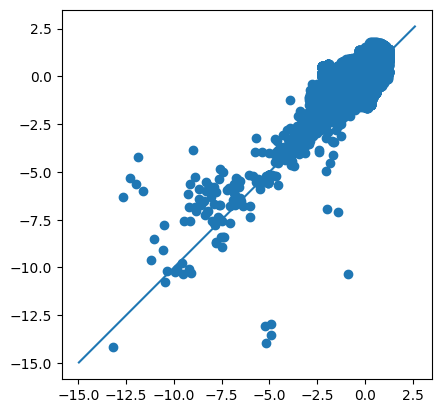

In [113]:
plt.scatter(y_true, y_predict)
ax = plt.gca()
ax.set_aspect('equal')
ax_min = min(list(ax.get_ylim() + ax.get_xlim()))
ax_max = max(list(ax.get_ylim() + ax.get_xlim()))
plt.plot([ax_min, ax_max], [ax_min, ax_max])
# plt.xscale('log')
# plt.yscale('log')
